In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc.gp as gp

# -------------------
# 1. Load Data and Library
# -------------------
df= pd.read_csv('params0704.csv')
tmp_df = df.copy()

n_dates = len(tmp_df)
observed_cases_arr = np.asarray(tmp_df['new_cases'].values, dtype='int32')
infectiousness_local_arr = np.asarray(tmp_df['infectiousness'].values, dtype='float32')
detection_prob_arr = np.clip(np.random.normal(loc=0.8, scale=0.05, size=n_dates), 0.5, 1.0).astype('float32')
valid_arr = np.ones(n_dates, dtype=bool)
time_tensor = np.arange(n_dates)[:, None].astype("float32")
inducing_date_nums = np.linspace(0, n_dates - 1, 15).astype("float32")[:, None]  # inducing points 

# -------------------
# 2. Setting PyMC Model
# -------------------
with pm.Model() as model:
    D_t_data = tmp_df['D_t']
    M_t_data = tmp_df['M_t']
    H_t_data = tmp_df['H_t']

    # Setting Prior 
    baseline_contact_params = [[2.2, 9, 1.05, 0.687], [0.06, 0.28, 1.68, 0.05]]
    HC = pm.Normal('HC', mu=baseline_contact_params[0][0], sigma=baseline_contact_params[1][0])
    NC = pm.Normal('NC', mu=baseline_contact_params[0][1], sigma=baseline_contact_params[1][1])
    HD = pm.Normal('HD', mu=baseline_contact_params[0][2], sigma=baseline_contact_params[1][2])
    ND = pm.Normal('ND', mu=baseline_contact_params[0][3], sigma=baseline_contact_params[1][3])
    p = pm.Normal('p', mu=0.885, sigma=0.08)
    eta = pm.Normal('eta', mu=0.035, sigma=0.01)
    infectiousdays = pm.Normal('infectiousdays', mu=4.519, sigma=2.892)

    # 관측된 D_t, M_t, H_t
    D_t = pm.Normal('si_t', mu=0, sigma=1, observed=D_t_data)
    M_t = pm.Normal('new_delta', mu=0, sigma=1, observed=M_t_data)
    H_t = pm.Normal('HD_t', mu=0, sigma=1, observed=H_t_data)

    # Calculate TP 
    household_t = HC * (1 - p ** (infectiousdays * H_t))
    nonhousehold_t = M_t * infectiousdays * (1 - p ** ND) * eta
    no_surv = household_t + nonhousehold_t

    if D_t!=0:
        TP_t = D_t*no_surv
    else:
        TP_t=no_surv    
    TP = pm.Deterministic('TP', pm.math.clip(TP_t, 1e-3, 1e6))  # 1e-6 대신 1e-3 권장
    log_TP = pm.math.log(TP)


    # Setting GP prior mean based on log(TP)
    log_TP = pm.math.log(TP)
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=0.5, lower=0)
    var = sigma ** 2
    mu_prior = log_TP - var


    # GP kernel 
    lengthscale = pm.Lognormal("lengthscale", mu=3, sigma=1)
    alpha = pm.Lognormal("alpha", mu=3, sigma=1)
    cov = gp.cov.RatQuad(1, ls=lengthscale, alpha=alpha)

    gp_latent = gp.Latent(cov_func=cov)
    epsilon_L = gp_latent.prior("epsilon_L", X=time_tensor)
    

    log_R_eff_local_t = mu_prior + epsilon_L
    R_eff_local_t = pm.Deterministic("R_eff_local_t", pm.math.exp(log_R_eff_local_t))

    # expected confirmed cases
    expected_infections = infectiousness_local_arr * R_eff_local_t
    expected_infections_vec = expected_infections[valid_arr]

    # Overdispersion
    sqrt_inv_size = pm.HalfNormal("sqrt_inv_size", sigma=0.2)
    size = 1.0 / pm.math.sqrt(sqrt_inv_size)
    size = pm.math.clip(size, 1e-3, 1e3)

    # Detection Probability Adjustment
    prob = 1 / (1 + expected_infections_vec / size)
    detection_prob_vec = detection_prob_arr[valid_arr]
    prob_trunc = 1 / (1 + detection_prob_vec * (1 - prob) / prob)
    prob_trunc = pm.math.clip(prob_trunc, 1e-6, 1 - 1e-6)

    # Modelling observed data 
    obs_cases = observed_cases_arr[valid_arr]
    pm.NegativeBinomial("obs", p=prob_trunc, n=size, observed=obs_cases)

    # Sampling
    trace = pm.sample(draws=1000, tune=500, chains=4, target_accept=0.95, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [HC, NC, HD, ND, p, eta, infectiousdays, sigma, lengthscale, alpha, epsilon_L_rotated_, sqrt_inv_size]


Sampling 2 chains for 50 tune and 100 draw iterations (100 + 200 draws total) took 16060 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


                   mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
HC                2.216   0.054    2.120    2.289      0.020    0.015   
NC                8.841   0.237    8.360    9.068      0.156    0.129   
HD                1.913   0.283    1.437    2.230      0.185    0.152   
ND                0.678   0.046    0.589    0.755      0.008    0.006   
p                 1.045   0.038    1.001    1.124      0.014    0.011   
eta               0.035   0.012    0.018    0.060      0.003    0.002   
infectiousdays    4.959   0.431    4.394    5.453      0.290    0.240   
sigma             0.052   0.028    0.024    0.091      0.019    0.015   
lengthscale     214.188  41.333  158.594  281.097     26.751   22.040   
alpha            40.765  10.073   26.856   56.899      6.699    5.533   
sqrt_inv_size     0.006   0.017    0.000    0.056      0.006    0.005   

                ess_bulk  ess_tail  r_hat  
HC                  10.0      54.0   1.22  
NC                   3.0      14.0 

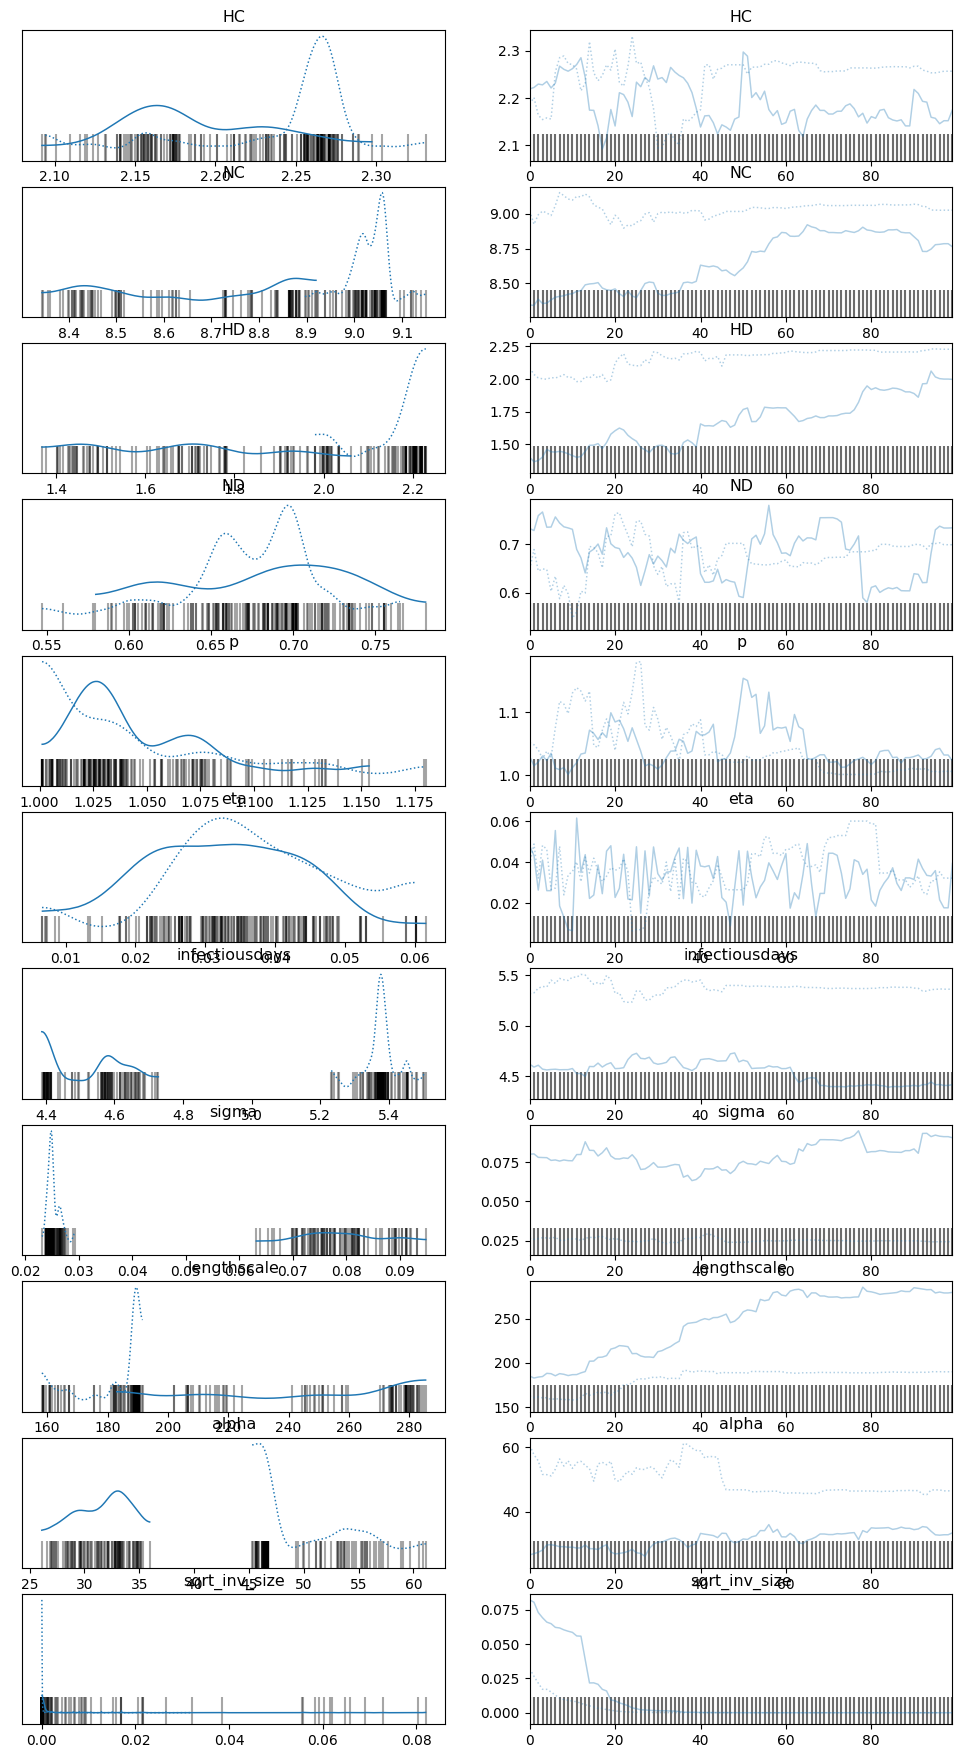

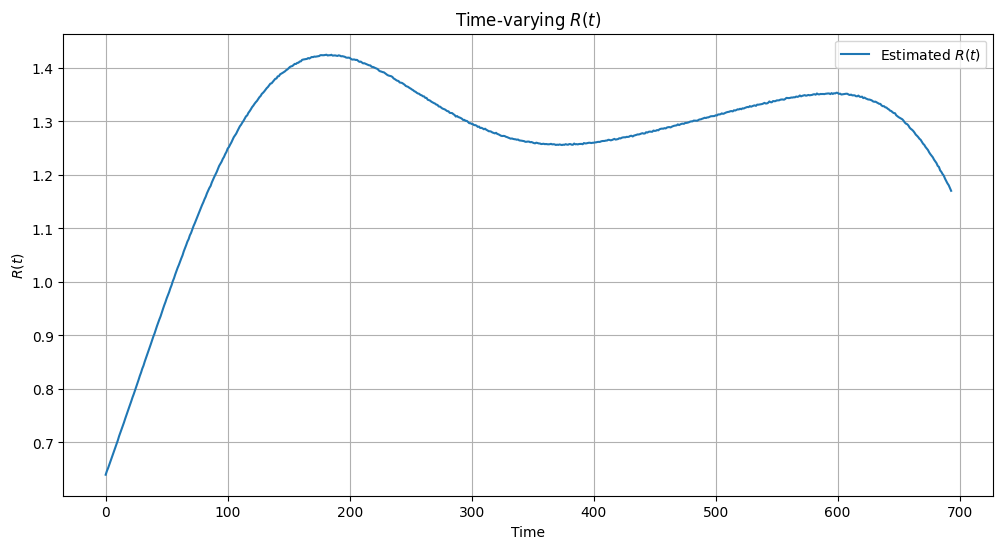

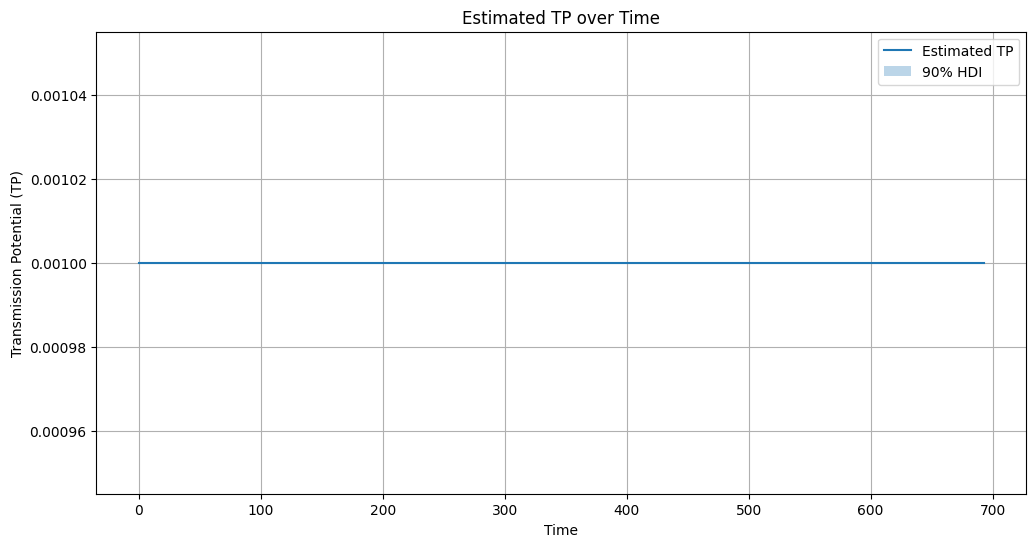

In [5]:
# 1. Display summary statistics for the model parameters
print(az.summary(trace, var_names=["HC", "NC", "HD", "ND", "p", "eta", "infectiousdays", "sigma", "lengthscale", "alpha", "sqrt_inv_size"]))

# 2. Visualize trace plots to assess parameter convergence
az.plot_trace(trace, var_names=["HC", "NC", "HD", "ND", "p", "eta", "infectiousdays", "sigma", "lengthscale", "alpha", "sqrt_inv_size"])
plt.show()

# 3. Plot timeseries of R(t) 
mean_R_eff = trace.posterior["R_eff_local_t"].mean(dim=("chain", "draw")).values.flatten()

plt.figure(figsize=(12, 6))
plt.plot(mean_R_eff, label="Estimated $R(t)$")
plt.title("Time-varying $R(t)$")
plt.xlabel("Time")
plt.ylabel("$R(t)$")
plt.legend()
plt.grid()
plt.show()


# 4. Plot timeseries of TP
mean_TP = trace.posterior["TP"].mean(dim=("chain", "draw")).values.flatten()
hdi_TP = az.hdi(trace, var_names=["TP"], hdi_prob=0.9)["TP"].to_numpy()

# 시계열 플롯
plt.figure(figsize=(12, 6))
plt.plot(mean_TP, label="Estimated TP")
plt.fill_between(np.arange(len(mean_TP)), hdi_TP[:, 0], hdi_TP[:, 1], alpha=0.3, label="90% HDI")
plt.title("Estimated TP over Time")
plt.xlabel("Time")
plt.ylabel("Transmission Potential (TP)")
plt.grid()
plt.legend()
plt.show()

In [ ]:
dates = pd.to_datetime(tmp_df['date'])

# -------------------------------
# 1. Rt 
# -------------------------------
Rt_samples = trace.posterior["R_eff_local_t"]
mean_Rt = Rt_samples.mean(dim=["chain", "draw"]).values.flatten()
hdi_Rt = az.hdi(Rt_samples, hdi_prob=0.9)
lower_Rt = hdi_Rt["R_eff_local_t"].sel(hdi="lower").values.flatten()
upper_Rt = hdi_Rt["R_eff_local_t"].sel(hdi="higher").values.flatten()

# -------------------------------
# 2. TP 
# -------------------------------
TP_samples = trace.posterior["TP"]
mean_TP = TP_samples.mean(dim=["chain", "draw"]).values.flatten()
hdi_TP = az.hdi(TP_samples, hdi_prob=0.9)
lower_TP = hdi_TP["TP"].sel(hdi="lower").values.flatten()
upper_TP = hdi_TP["TP"].sel(hdi="higher").values.flatten()

# -------------------------------
# 3. Expected Confirmed Cases
# -------------------------------
expected_infections_samples = Rt_samples * infectiousness_local_arr
mean_expected = expected_infections_samples.mean(dim=["chain", "draw"]).values.flatten()
hdi_expected = az.hdi(expected_infections_samples, hdi_prob=0.9)
lower_expected = hdi_expected["R_eff_local_t"].sel(hdi="lower").values.flatten()
upper_expected = hdi_expected["R_eff_local_t"].sel(hdi="higher").values.flatten()

# -------------------------------
# 4. incidence
# -------------------------------
incidence = tmp_df['new_cases'].values

# -------------------------------
# 5. Make DataFrame
# -------------------------------
df_summary = pd.DataFrame({
    "date": dates,
    "mean_Rt": mean_Rt,
    "lower_Rt": lower_Rt,
    "upper_Rt": upper_Rt,
    "mean_TP": mean_TP,
    "lower_TP": lower_TP,
    "upper_TP": upper_TP,
    "mean_expected_infections": mean_expected,
    "lower_expected_infections": lower_expected,
    "upper_expected_infections": upper_expected,
    "incidence": incidence
})

# -------------------------------
# 6. Save the Results
# -------------------------------
# df_summary.to_csv("mcmc0705.csv", index=False)
# df_scalar = trace.posterior[["HC", "NC", "HD", "ND", "p", "eta", "infectiousdays", "sigma", "lengthscale", "alpha", "sqrt_inv_size"]].to_dataframe().reset_index()
# df_scalar.to_csv("posterior_scalar_parameters.csv", index=False)



,date,mean_Rt,lower_Rt,upper_Rt,mean_TP,lower_TP,upper_TP,mean_expected_infections,lower_expected_infections,upper_expected_infections,incidence
0,2020-02-16,0.639674,0.509359,0.760356,0.001,0.001,0.001,0.000000,0.000000,0.000000,0.0
1,2020-02-17,0.646653,0.516649,0.767415,0.001,0.001,0.001,0.000000,0.000000,0.000000,0.0
2,2020-02-18,0.652200,0.523537,0.771456,0.001,0.001,0.001,0.000000,0.000000,0.000000,2.0
3,2020-02-19,0.658750,0.531615,0.776562,0.001,0.001,0.001,0.000000,0.000000,0.000000,0.0
4,2020-02-20,0.665347,0.539434,0.781779,0.001,0.001,0.001,0.000000,0.000000,0.000000,16.0
...,...,...,...,...,...,...,...,...,...,...,...
689,2022-01-05,1.188460,1.089965,1.266047,0.001,0.001,0.001,4624.249858,4241.007834,4926.135335,4125.0
690,2022-01-06,1.184185,1.081970,1.264316,0.001,0.001,0.001,4358.725890,3982.494658,4653.670546,3714.0
691,2022-01-07,1.180837,1.075234,1.264496,0.001,0.001,0.001,4344.487131,3955.957012,4652.282180,3510.0
692,2022-01-08,1.175493,1.057470,1.250715,0.001,0.001,0.001,4455.323797,4007.996763,4740.431458,3368.0


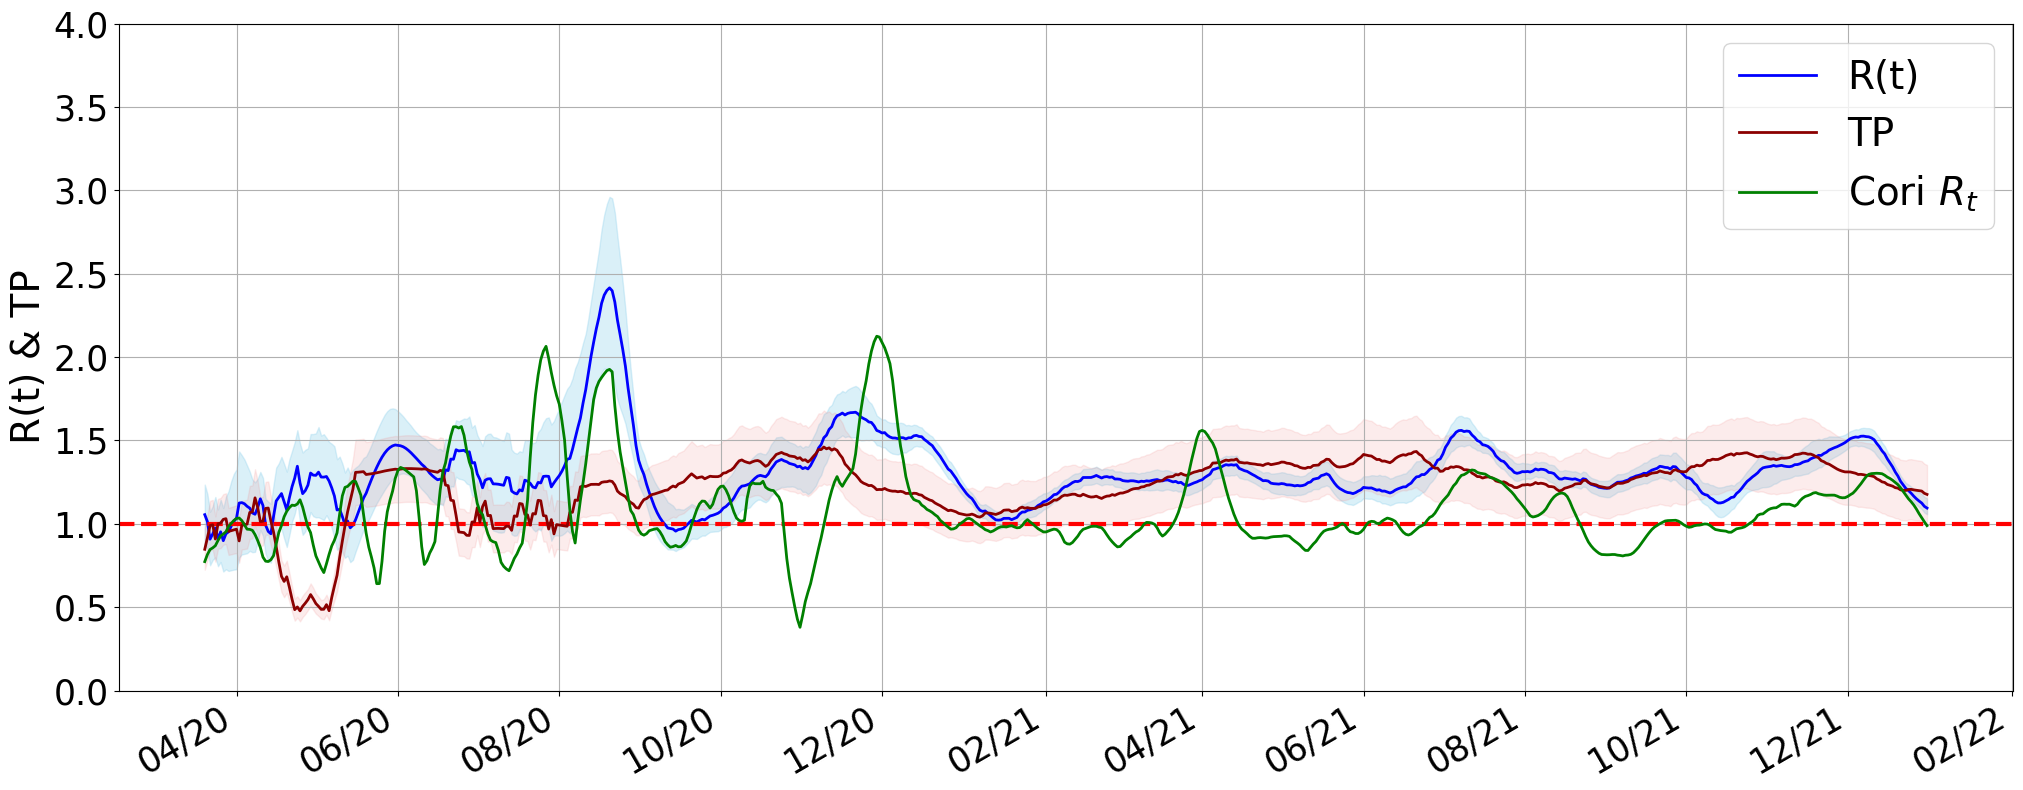

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

df = pd.read_csv("mcmc0705.csv")
df['date']=pd.to_datetime(df['date'])

fig, ax = plt.subplots(figsize=(20, 8))

# Rt
ax.fill_between(df['date'], df['lower_Rt'], df['upper_Rt'], color='skyblue', alpha=0.3)
ax.plot(df['date'], df['mean_Rt'], color='blue', label="R(t)", linewidth=2)
ax.axhline(1.0, color='red', linestyle='--', linewidth=3)

# TP
ax.fill_between(df['date'],  df['lower_TP'],  df['upper_TP'], color='lightcoral', alpha=0.15)
ax.plot(df['date'],  df['mean_TP'], color='darkred', label="TP", linewidth=2)

ax.set_ylim(0, 4)

ax.plot(df['date'], df['Cori_Rt'], color='green', label="Cori $R_t$", linewidth=2)


# y축, 기타 설정
ax.set_ylabel("R(t) & TP", fontsize=28)





# 날짜 포맷
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

ax.legend(fontsize=28)

ax.grid()
ax.tick_params(axis='both', labelsize=25)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


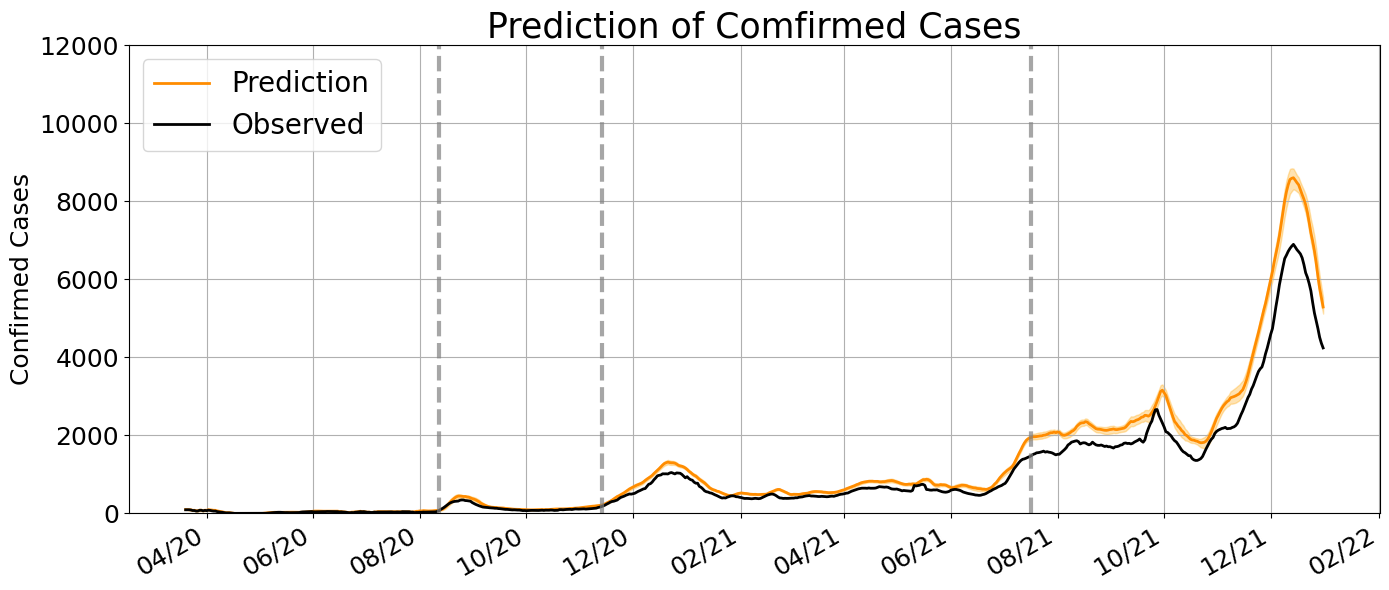

In [48]:
df = pd.read_csv("mcmc0705.csv")
df['date'] = pd.to_datetime(df['date'])

fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(df['date'], df['lower_expected'], df['upper_expected'], color='orange', alpha=0.3)
ax.plot(df['date'], df['mean_expected'], color='darkorange', label="Prediction", linewidth=2)

ax.plot(df['date'], df['incidence'], color='black', label="Observed", linewidth=2)

ax.set_ylabel("Confirmed Cases", fontsize=18)
ax.set_title("Prediction of Comfirmed Cases", fontsize=25)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.set_ylim([0, 12000])

ax.grid()
dates = ['2020-08-12', '2020-11-13', '2021-07-17']
for date in dates:
    ax.axvline(pd.to_datetime(date), alpha=0.7, color='grey', linestyle='--', linewidth=3)


ax.legend(fontsize=20,loc='upper left')
ax.tick_params(axis='both', labelsize=18)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

expected = df['mean_expected']
actual = df['incidence']

mask = ~np.isnan(expected) & ~np.isnan(actual)
expected_clean = expected[mask]
actual_clean = actual[mask]

# MAE, MSE, R² 
mae = mean_absolute_error(actual_clean, expected_clean)
mse = mean_squared_error(actual_clean, expected_clean)
r2 = r2_score(actual_clean, expected_clean)

print(f"MAE: {mae:.3f}")
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

MAE: 245.464
RMSE: 437.127
R²: 0.896
